#1.Unzip the dataset

Since sharing dataset was prohibited I did not upload it in my repo

In [ ]:
! unzip /content/drive/MyDrive/dk-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/negative/Sample_237.jpg  
  inflating: dataset/train/negative/Sample_304.jpg  
  inflating: dataset/train/negative/Sample_2829.jpg  
  inflating: dataset/train/negative/Sample_2310.jpg  
  inflating: dataset/train/negative/Sample_944.jpg  
  inflating: dataset/train/negative/Sample_1393.jpg  
  inflating: dataset/train/negative/Sample_2370.jpg  
  inflating: dataset/train/negative/Sample_2105.jpg  
  inflating: dataset/train/negative/Sample_226.jpg  
  inflating: dataset/train/negative/Sample_1141.jpg  
  inflating: dataset/train/negative/Sample_3898.jpg  
  inflating: dataset/train/negative/Sample_1598.jpg  
  inflating: dataset/train/negative/Sample_399.jpg  
  inflating: dataset/train/negative/Sample_247.jpg  
  inflating: dataset/train/negative/Sample_862.jpg  
  inflating: dataset/train/negative/Sample_1388.jpg  
  inflating: dataset/train/negative/Sample_2620.jpg  
  inflating: dataset/train/negative/Sa

#2.Import Tensorflow and os

In [ ]:
import os
import tensorflow as tf

#3.Making directories for test and train data

In [ ]:
os.mkdir('/content/pos-v-neg')
os.mkdir('/content/pos-v-neg/training')
os.mkdir('/content/pos-v-neg/testing')
os.mkdir('/content/pos-v-neg/training/positive')
os.mkdir('/content/pos-v-neg/training/negative')
os.mkdir('/content/pos-v-neg/testing/positive')
os.mkdir('/content/pos-v-neg/testing/negative')

#4.Train Test split

Writing a function to randomly select some of the images as training and the others as test set and copying each of them into their directory 

In [ ]:
from shutil import copyfile
import random
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name)

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

In [ ]:
Pos_SOURCE_DIR = "/content/dataset/train/positive/"
TRAINING_Pos_DIR = "/content/pos-v-neg/training/positive/"
TESTING_Pos_DIR = "/content/pos-v-neg/testing/positive/"
Neg_SOURCE_DIR = "/content/dataset/train/negative/"
TRAINING_Neg_DIR = "/content/pos-v-neg/training/negative/"
TESTING_Neg_DIR = "/content/pos-v-neg/testing/negative/"

split_size = .9
split_data(Pos_SOURCE_DIR, TRAINING_Pos_DIR, TESTING_Pos_DIR , split_size)
split_data(Neg_SOURCE_DIR, TRAINING_Neg_DIR, TESTING_Neg_DIR, split_size)

#5.Plotting some of the images

(512, 512, 3)

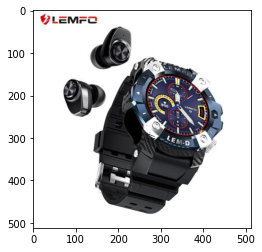

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
pos_name = os.listdir(Pos_SOURCE_DIR)
r = np.random.randint(1,len(pos_name))
img = mpimg.imread(os.path.join(Pos_SOURCE_DIR,pos_name[r]))
plt.imshow(img)
img.shape

#6.Loading datasets

Using (amazing!!) ImageDataGenerator to import training set and test set but first we augment images 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen  = ImageDataGenerator(rescale = 1./255)
train_dir = '/content/pos-v-neg/training/'
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
validation_dir = '/content/pos-v-neg/testing'
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=16,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 7722 images belonging to 2 classes.
Found 860 images belonging to 2 classes.


#7.Defining Model

In [ ]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

#8.Compiling Model

In [ ]:
model.compile('rmsprop',
              loss='binary_crossentropy',
              metrics = ['accuracy'])

#9.Fitting model

In [ ]:
history = model.fit(
            train_generator,
            steps_per_epoch=7722 // 16,
            epochs=40,
            validation_data=validation_generator,
            validation_steps=860 // 16
            )
model.save('my_model.h5')

Epoch 1/40
 72/482 [===>..........................] - ETA: 1:03 - loss: 0.6666 - accuracy: 0.5816

#10.Predicting the results

We first need to use load-img to change image size and rescaling it.

In [ ]:
name=[]
lable=[]
SOURCE = '/content/dataset/test'
for file_name in os.listdir(SOURCE):
  name.append(file_name)
  file_path = os.path.join(SOURCE, file_name)
  img = tf.keras.preprocessing.image.load_img(
    file_path, grayscale=False, color_mode="rgb", target_size=(150,150), interpolation="nearest")
  input_arr = tf.keras.preprocessing.image.img_to_array(img)/255
  lable.append(int(model.predict(np.array([input_arr]))))

#11.Checking lables

In [ ]:
set(lable)

{0, 1}

#12.Exporting the desiered result

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(name,columns=['name'])
df

,name
0,7563aa94-9c16-46cf-bff4-ff9bb6835d90.jpg
1,2a00078c-6fc1-4a69-bf0b-dbe175804cca.jpg
2,95c2fa4f-154c-4639-a56f-3faf5e117e18.jpg
3,eeeb0c13-1a28-493b-88db-d675d91d26ed.jpg
4,5480900d-29b4-4116-bd8c-9fa7c3f457e2.jpg
...,...
1098,13f9a324-15e5-4ff4-b703-7290c251d1fc.jpg
1099,484e96f6-3194-4bff-92fb-81d9daf2f5d4.jpg
1100,8c2128f7-67fa-4e84-851f-a9bf0615edc6.jpg
1101,2340de22-7ede-4206-8064-f77998db32bf.jpg


In [ ]:
df['predicted'] = lable
df

,name,predicted
0,7563aa94-9c16-46cf-bff4-ff9bb6835d90.jpg,0
1,2a00078c-6fc1-4a69-bf0b-dbe175804cca.jpg,0
2,95c2fa4f-154c-4639-a56f-3faf5e117e18.jpg,0
3,eeeb0c13-1a28-493b-88db-d675d91d26ed.jpg,0
4,5480900d-29b4-4116-bd8c-9fa7c3f457e2.jpg,0
...,...,...
1098,13f9a324-15e5-4ff4-b703-7290c251d1fc.jpg,0
1099,484e96f6-3194-4bff-92fb-81d9daf2f5d4.jpg,0
1100,8c2128f7-67fa-4e84-851f-a9bf0615edc6.jpg,0
1101,2340de22-7ede-4206-8064-f77998db32bf.jpg,0


In [ ]:
df.to_csv('output.csv',index=False)